In [466]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import pydotplus
import matplotlib.pyplot as plt
import random

In [467]:
class DecisionTree(object):
    def __init__(self,dataframe):
        self.model = None
        self.dataframe = dataframe
        self.X_train = None
        self.Y_train = None 
        self.Y_train_pred = None
        self.X_test = None
        self.Y_test = None
        self.Y_test_pred = None
        self.mse_train = None
        self.mse_test = None
        self.max_depth = None
        self.min_node_size = None
        self.processing()
    
    def processing(self):
        self.dataframe["Urban"] = self.dataframe["Urban"].replace("No",0)
        self.dataframe["Urban"] = self.dataframe["Urban"].replace("Yes",1)
        self.dataframe["US"] = self.dataframe["US"].replace("No",0)
        self.dataframe["US"] = self.dataframe["US"].replace("Yes",1)
        self.dataframe = self.dataframe.join(pd.get_dummies(self.dataframe.ShelveLoc))
        self.dataframe = self.dataframe.drop(columns=['ShelveLoc'])
        self.Y_train = self.dataframe.iloc[:300,0].values
        self.Y_test = self.dataframe.iloc[301:,0].values
        self.X_train = self.dataframe.iloc[:300,1:].values
        self.X_test = self.dataframe.iloc[301:,1:].values
        
    def fit_dt(self,max_depth=None,min_node_size=2):
        model = tree.DecisionTreeRegressor(max_depth=max_depth,min_samples_leaf=min_node_size,random_state=0)
        model.fit(self.X_train,self.Y_train)
        self.Y_test_pred = model.predict(self.X_test)
        self.Y_train_pred = model.predict(self.X_train)
        self.mse_train = mean_squared_error(self.Y_train,self.Y_train_pred)
        self.mse_test = mean_squared_error(self.Y_test,self.Y_test_pred)
        self.model = model
        self.max_depth = max_depth
        self.min_node_size = min_node_size
        
    def fit_bagging(self,number_of_trees,max_depth=None,min_node_size=2):
        model = RandomForestRegressor(max_depth=max_depth,min_samples_leaf=min_node_size,random_state=0,n_estimators=number_of_trees,max_features=None,bootstrap=True)
        model.fit(self.X_train,self.Y_train)
        self.Y_test_pred = model.predict(self.X_test)
        self.Y_train_pred = model.predict(self.X_train)
        self.mse_train = mean_squared_error(self.Y_train,self.Y_train_pred)
        self.mse_test = mean_squared_error(self.Y_test,self.Y_test_pred)
        self.model = model
        self.max_depth = max_depth
        self.min_node_size = min_node_size
        
    def fit_random_forests(self,m,number_of_trees,max_depth=None,min_node_size=2):
        model = RandomForestRegressor(max_depth=max_depth,min_samples_leaf=min_node_size,random_state=0,n_estimators=number_of_trees,max_features=m,bootstrap=True)
        model.fit(self.X_train,self.Y_train)
        self.Y_test_pred = model.predict(self.X_test)
        self.Y_train_pred = model.predict(self.X_train)
        self.mse_train = mean_squared_error(self.Y_train,self.Y_train_pred)
        self.mse_test = mean_squared_error(self.Y_test,self.Y_test_pred)
        self.model = model
        self.max_depth = max_depth
        self.min_node_size = min_node_size
        
    def plot_tree(self):
        dot_data = tree.export_graphviz(self.model, out_file=None, 
                         feature_names=self.dataframe.columns.values.tolist()[1:],  
                         class_names=self.dataframe.columns.values.tolist()[0],  
                         filled=True, rounded=True,  
                         special_characters=True)  
        graph = pydotplus.graph_from_dot_data(dot_data)
        graph.write_pdf("tree_%s_%s.pdf"%(str(self.max_depth),str(self.min_node_size)))
        
    def bias_variance_analysis(self,max_depth=None,min_node_size=2):
        X_dataset = []
        Y_dataset = []
        index_list = [i for i in range(0,300)]
        for i in range(10):
            random.shuffle(index_list)
            X_dataset.append([self.X_train[j] for j in index_list[:200]])
            Y_dataset.append([self.Y_train[j] for j in index_list[:200]])
        number_of_trees = [i for i in range(10,301,10)]
        bias_2_list = []
        variance_list = []
        for num in range(len(number_of_trees)):
            model_Y_pred = []
            for i in range(10):
                model = RandomForestRegressor(max_depth=max_depth,min_samples_leaf=min_node_size,random_state=0,n_estimators=number_of_trees[num],max_features=None,bootstrap=True)
                model.fit(X_dataset[i],Y_dataset[i])
                model_Y_pred.append(model.predict(self.X_test))
            h_bar = sum(model_Y_pred)/10
            bias_2 = np.sum((h_bar-self.Y_test)**2)/100
            bias_2_list.append(bias_2)
            dataset_var = []
            for Y in model_Y_pred:
                D_var = np.sum((Y-h_bar)**2)/100
                dataset_var.append(D_var)
            var = sum(dataset_var)/10
            variance_list.append(var)
        plt.plot(number_of_trees,bias_2_list)
        plt.xlabel('Numbers of trees')
        plt.ylabel('Bias^2')
        plt.title('m = None,max_depth = 15,least_node_size = 5')
        plt.show()
        plt.plot(number_of_trees,variance_list)
        plt.xlabel('Numbers of trees')
        plt.ylabel('Variance')
        plt.title('m = None,max_depth = 15,least_node_size = 5')
        plt.show()
        

In [468]:
df = pd.read_csv("Carseats.csv")

In [469]:
def data_statistics(df):
    target = df.iloc[:,0].values
    features = np.transpose(df.iloc[:,1:].values)
    plt.hist(target,bins=20)
    plt.xlabel('Sales')
    plt.ylabel('frequency')
    plt.show()
    for i in range(10):
        plt.hist(features[i],bins=20)
        if i == 0:
            plt.xlabel('CompPrice')
        if i == 1:
            plt.xlabel('Income')
        if i == 2:
            plt.xlabel('Advertising')
        if i == 3:
            plt.xlabel('Population')
        if i == 4:
            plt.xlabel('Price')
        if i == 5:
            plt.xlabel('ShelveLoc')
        if i == 6:
            plt.xlabel('Age')
        if i == 7:
            plt.xlabel('Education')
        if i == 8:
            plt.xlabel('Urban')
        if i == 9:
            plt.xlabel('US')
        plt.ylabel('frequency')
        plt.show()

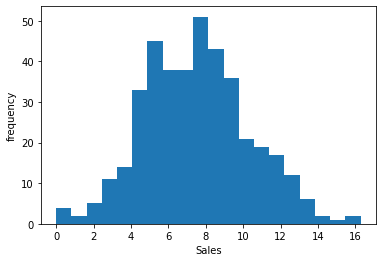

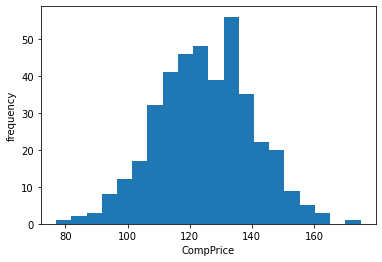

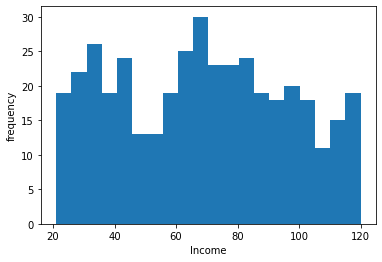

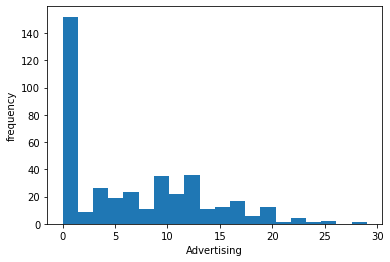

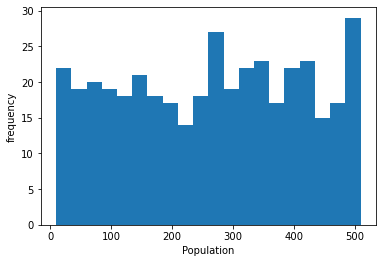

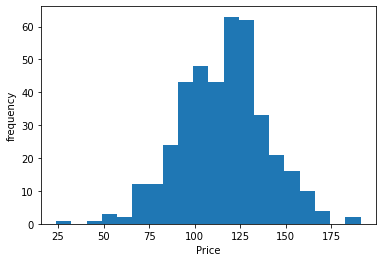

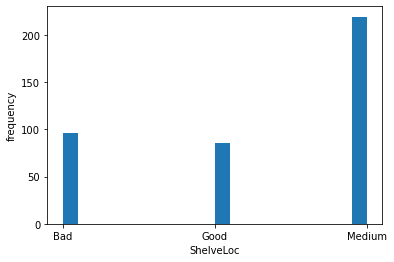

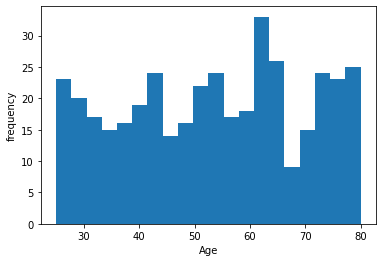

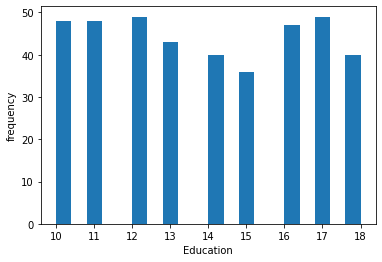

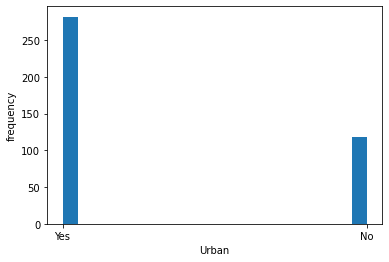

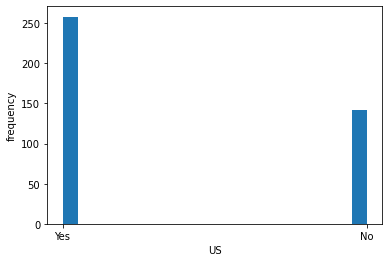

In [470]:
data_statistics(df)

In [471]:
dt = DecisionTree(df)

In [472]:
for i in [3,4,5]:
    for j in [10,15,20]:
        dt.fit_dt(i,j)
        dt.plot_tree()
        print("Maximum depth=%d;Least node sizes=%d: train error=%f"%(i,j,dt.mse_train))
        print("Maximum depth=%d;Least node sizes=%d: test error=%f"%(i,j,dt.mse_test))

Maximum depth=3;Least node sizes=10: train error=3.872804
Maximum depth=3;Least node sizes=10: test error=5.706664
Maximum depth=3;Least node sizes=15: train error=3.966136
Maximum depth=3;Least node sizes=15: test error=5.749041
Maximum depth=3;Least node sizes=20: train error=4.076576
Maximum depth=3;Least node sizes=20: test error=5.412308
Maximum depth=4;Least node sizes=10: train error=3.175644
Maximum depth=4;Least node sizes=10: test error=5.472547
Maximum depth=4;Least node sizes=15: train error=3.381846
Maximum depth=4;Least node sizes=15: test error=5.231955
Maximum depth=4;Least node sizes=20: train error=3.489454
Maximum depth=4;Least node sizes=20: test error=4.936841
Maximum depth=5;Least node sizes=10: train error=2.475642
Maximum depth=5;Least node sizes=10: test error=5.171406
Maximum depth=5;Least node sizes=15: train error=2.945208
Maximum depth=5;Least node sizes=15: test error=5.190623
Maximum depth=5;Least node sizes=20: train error=3.196852
Maximum depth=5;Least 

In [473]:
for i in [10,30,50,70,90,110,130,150]:
    for j in [5,6,7]:
        dt.fit_bagging(i,j)
        print("Number of trees=%d;Maximum depth=%d: train error=%f"%(i,j,dt.mse_train))
        print("Number of trees=%d;Maximum depth=%d: test error=%f"%(i,j,dt.mse_test))

Number of trees=10;Maximum depth=5: train error=1.539127
Number of trees=10;Maximum depth=5: test error=3.648737
Number of trees=10;Maximum depth=6: train error=1.105240
Number of trees=10;Maximum depth=6: test error=3.530226
Number of trees=10;Maximum depth=7: train error=0.934483
Number of trees=10;Maximum depth=7: test error=3.469638
Number of trees=30;Maximum depth=5: train error=1.439148
Number of trees=30;Maximum depth=5: test error=3.237845
Number of trees=30;Maximum depth=6: train error=0.999964
Number of trees=30;Maximum depth=6: test error=3.155788
Number of trees=30;Maximum depth=7: train error=0.769961
Number of trees=30;Maximum depth=7: test error=3.114112
Number of trees=50;Maximum depth=5: train error=1.405026
Number of trees=50;Maximum depth=5: test error=3.153136
Number of trees=50;Maximum depth=6: train error=0.967992
Number of trees=50;Maximum depth=6: test error=3.079383
Number of trees=50;Maximum depth=7: train error=0.732481
Number of trees=50;Maximum depth=7: tes

In [474]:
for i in [3,4,5]:
    for j in [10,30,50,70,90,110,130,150]:
        dt.fit_random_forests(i,j)
        print("Max features=%d;Number of trees=%d: train error=%f"%(i,j,dt.mse_train))
        print("Max features=%d;Number of trees=%d: test error=%f"%(i,j,dt.mse_test))

Max features=3;Number of trees=10: train error=1.104304
Max features=3;Number of trees=10: test error=3.493380
Max features=3;Number of trees=30: train error=0.902824
Max features=3;Number of trees=30: test error=2.902448
Max features=3;Number of trees=50: train error=0.868971
Max features=3;Number of trees=50: test error=2.884367
Max features=3;Number of trees=70: train error=0.867453
Max features=3;Number of trees=70: test error=2.889716
Max features=3;Number of trees=90: train error=0.880094
Max features=3;Number of trees=90: test error=2.911878
Max features=3;Number of trees=110: train error=0.882999
Max features=3;Number of trees=110: test error=2.897184
Max features=3;Number of trees=130: train error=0.878182
Max features=3;Number of trees=130: test error=2.908986
Max features=3;Number of trees=150: train error=0.872342
Max features=3;Number of trees=150: test error=2.911225
Max features=4;Number of trees=10: train error=0.938075
Max features=4;Number of trees=10: test error=2.90

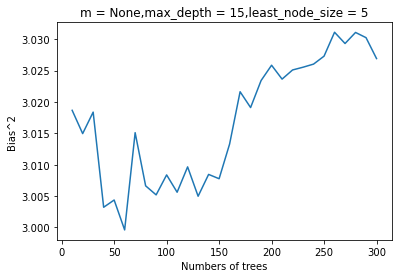

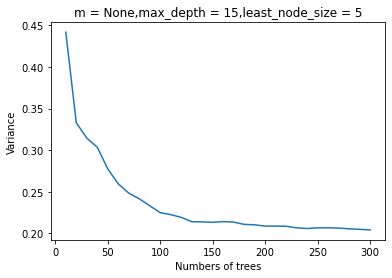

In [475]:
dt.bias_variance_analysis(15,5)